100%|██████████| 9.91M/9.91M [00:00<00:00, 34.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.24MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.95MB/s]


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch [1/5], Train Acc: 95.44%, Test Acc: 98.48%
Epoch [2/5], Train Acc: 98.61%, Test Acc: 98.83%
Epoch [3/5], Train Acc: 98.98%, Test Acc: 98.91%
Epoch [4/5], Train Acc: 99.28%, Test Acc: 99.00%
Epoch [5/5], Train Acc: 99.47%, Test Acc: 99.11%


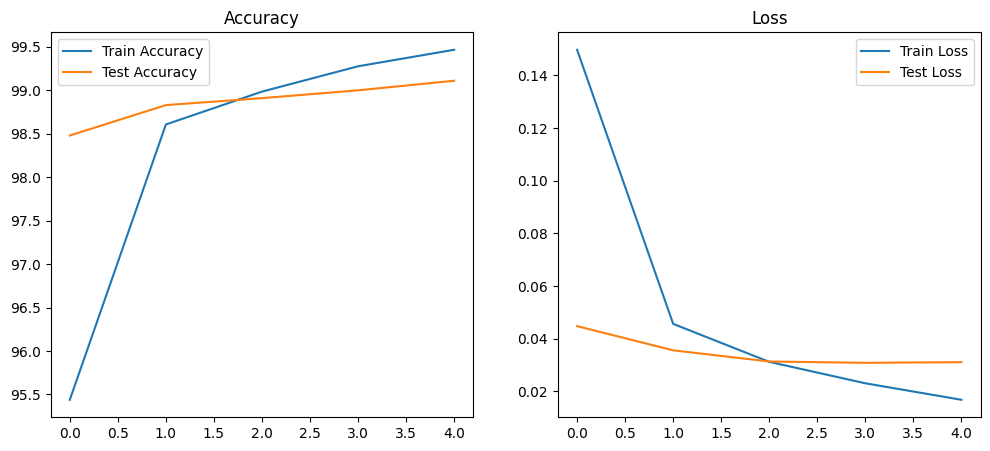

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       980
         1.0       0.99      1.00      0.99      1135
         2.0       0.99      1.00      0.99      1032
         3.0       0.99      1.00      0.99      1010
         4.0       0.99      0.99      0.99       982
         5.0       0.98      0.99      0.99       892
         6.0       0.99      0.99      0.99       958
         7.0       0.99      0.99      0.99      1028
         8.0       1.00      0.98      0.99       974
         9.0       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



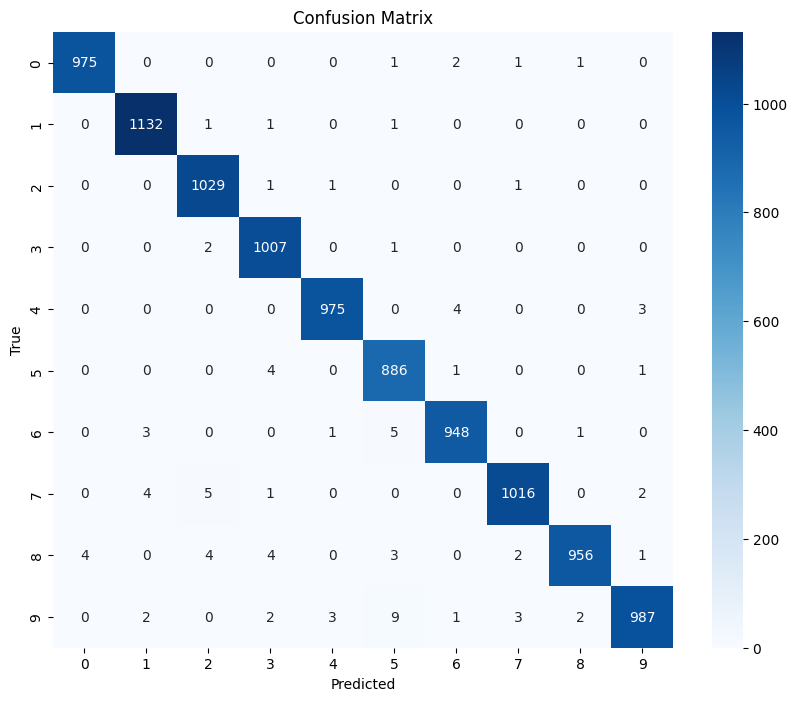

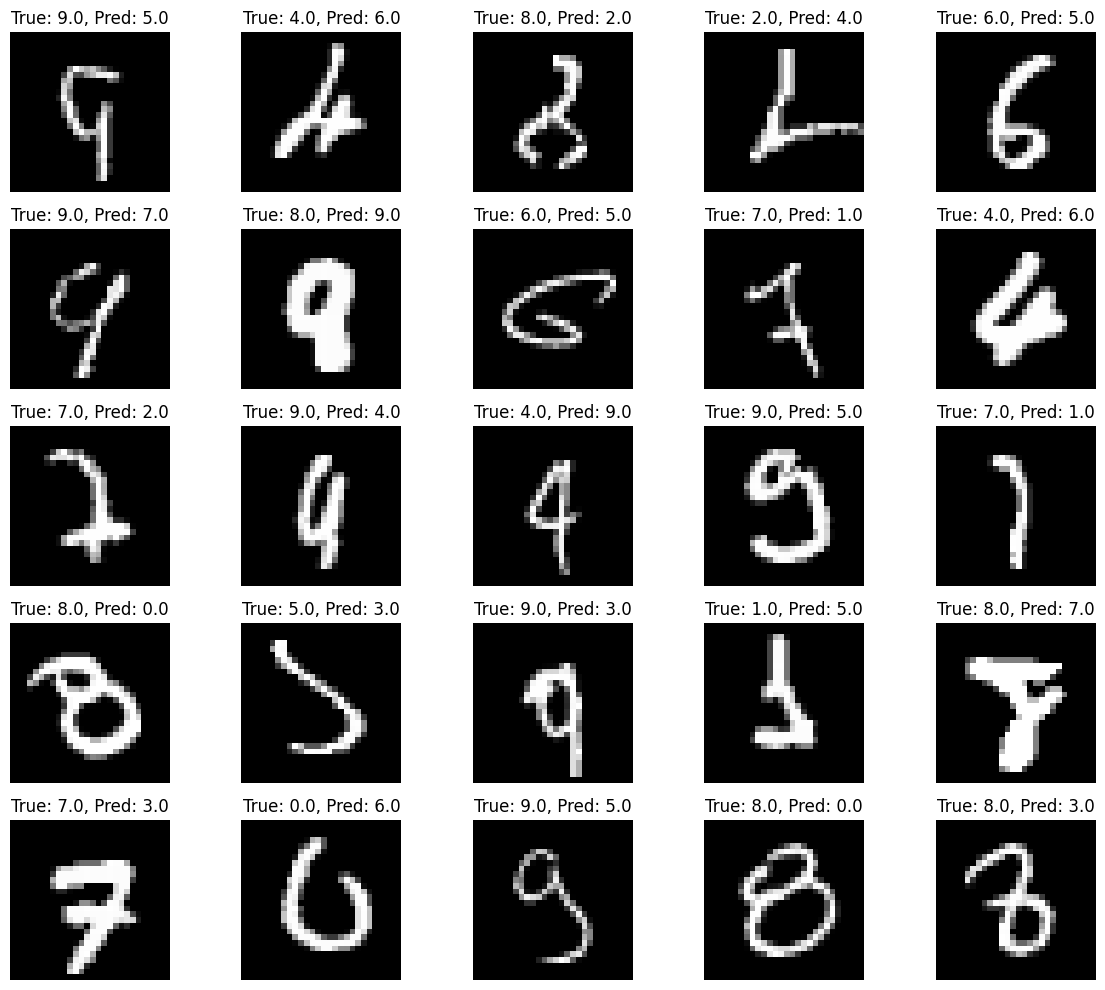

In [ ]:
# Handwritten Digit Recognition using CNN on MNIST with PyTorch (Google Colab)

# Part 1: Data Preparation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Transform: Normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Part 2: Model Design
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv + ReLU + Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv + ReLU + Pool
        x = x.view(-1, 64 * 5 * 5)             # Flatten
        x = F.relu(self.fc1(x))               # Fully connected layer
        x = self.fc2(x)                       # Output layer
        return x

model = CNNModel()
print(model)

# Part 3: Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(5):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/5], Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Part 4: Evaluation
model.eval()
all_preds = torch.tensor([])
all_labels = torch.tensor([])

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Misclassified Digits
misclassified = torch.where(all_preds != all_labels)[0]
plt.figure(figsize=(12, 10))
for i, idx in enumerate(misclassified[:25]):
    image = test_dataset[idx][0].squeeze()
    true_label = all_labels[idx].item()
    pred_label = all_preds[idx].item()
    plt.subplot(5, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.07MB/s]


Epoch [1/5], Train Acc: 83.69%, Test Acc: 98.21%
Epoch [2/5], Train Acc: 93.44%, Test Acc: 98.43%
Epoch [3/5], Train Acc: 95.07%, Test Acc: 98.76%
Epoch [4/5], Train Acc: 95.79%, Test Acc: 99.08%
Epoch [5/5], Train Acc: 96.28%, Test Acc: 99.10%


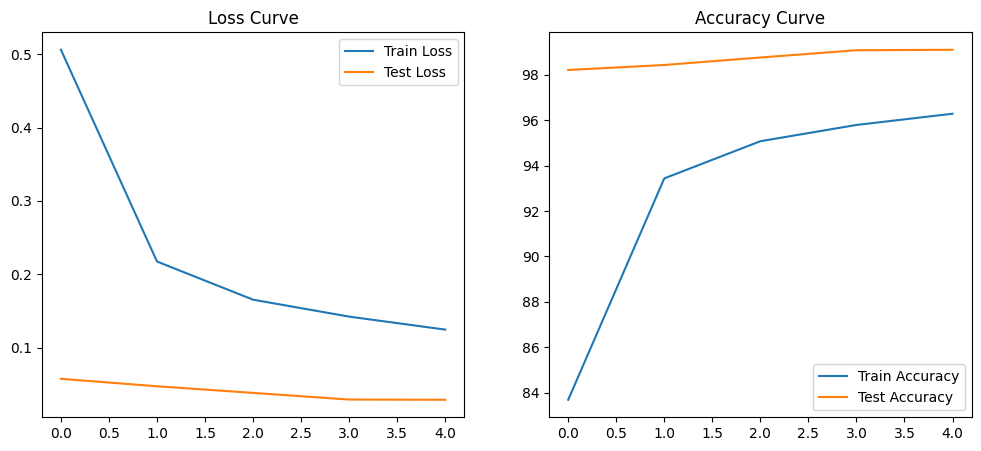

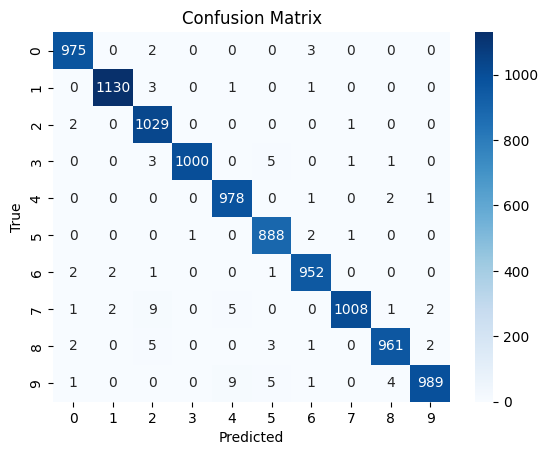

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.98      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.98      1.00      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.98      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



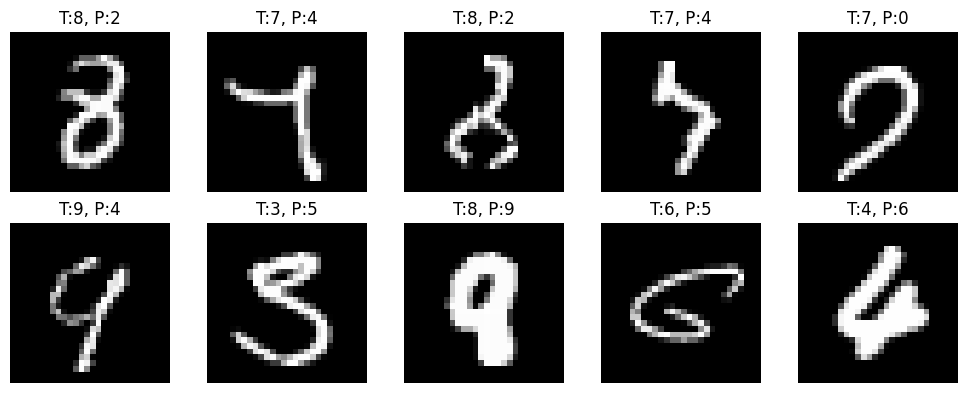

In [ ]:
# ====================================
# Handwritten Digit Recognition with CNN on MNIST + Dropout + Data Augmentation
# ====================================

# Step 1: Install & Import Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 2: Data Preparation (with augmentation)
transform_augmented = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform_augmented, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Step 3: CNN Model with Dropout
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNNModel().to(device)

# Step 4: Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Training the Model
num_epochs = 5
train_loss, test_loss, train_acc, test_acc = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    correct, total, epoch_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(epoch_loss / len(train_loader))
    train_acc.append(100 * correct / total)

    # Evaluate on test set
    model.eval()
    correct, total, epoch_loss = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss.append(epoch_loss / len(test_loader))
    test_acc.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc[-1]:.2f}%, Test Acc: {test_acc[-1]:.2f}%")

# Step 6: Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Step 7: Confusion Matrix & Classification Report
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Step 8: Display Misclassified Images
misclassified = [(img, p, l) for img, p, l in zip(test_dataset.data, all_preds, all_labels) if p != l]
plt.figure(figsize=(10, 4))
for i in range(10):
    img, pred, true = misclassified[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'T:{true}, P:{pred}')
    plt.axis('off')
plt.tight_layout()
plt.show()


X_test shape: (100, 30, 17)
y_test shape: (100,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 30, 64)              │          20,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,497 (134.75 KB)

 Trainable params: 34,497 (134.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 9589.0117 - mae: 79.5548 - val_loss: 6487.0679 - val_mae: 62.2788
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 3698.4702 - mae: 49.2970 - val_loss: 5444.6060 - val_mae: 59.0010
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 3512.5166 - mae: 48.6258 - val_loss: 5477.6260 - val_mae: 59.0648
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 3095.8831 - mae: 44.6371 - val_loss: 3861.2351 - val_mae: 45.8506
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 2137.0317 - mae: 35.0805 - val_loss: 2760.9724 - val_mae: 37.6649
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 1384.0038 - mae: 26.4673 - val_loss: 2038.0496 - val_mae: 30.8597
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 1069.1180 - mae: 22.7186 - val_loss: 1828.3335 - val_mae: 29.1124
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 993.1693 - mae: 21.5811 - val_loss: 1960.99

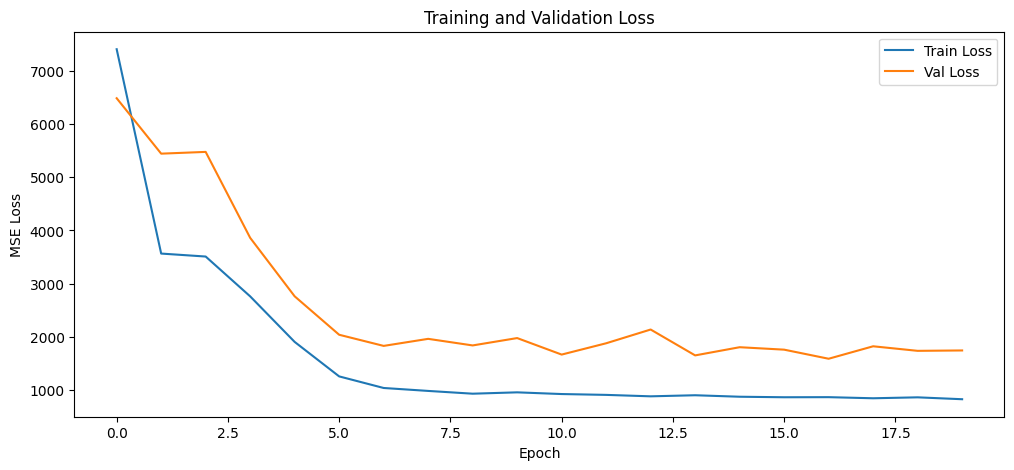

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
RMSE: 21.38
MAE: 14.99


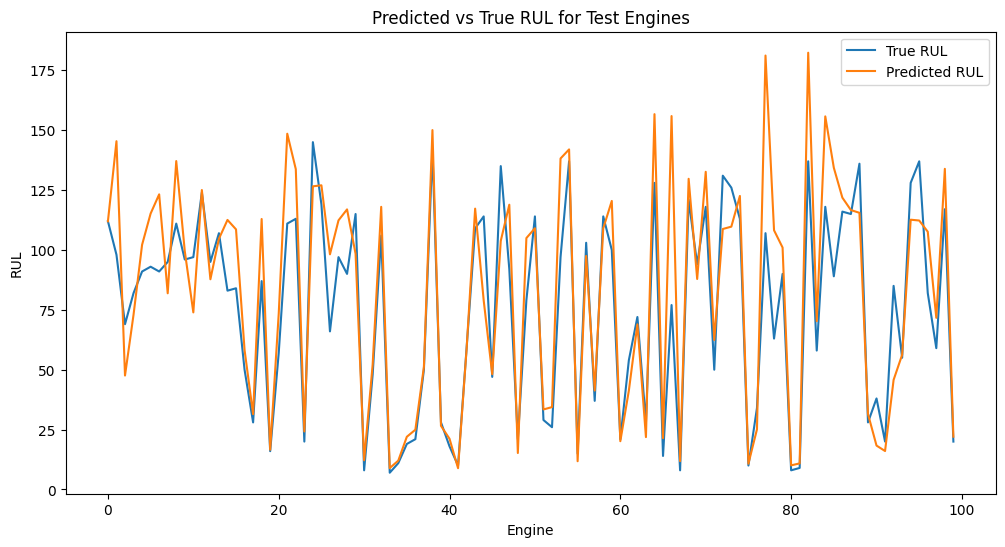

Engine 1: True RUL = 112, Predicted RUL = 111.95
Engine 2: True RUL = 98, Predicted RUL = 145.39
Engine 3: True RUL = 69, Predicted RUL = 47.57
Engine 4: True RUL = 82, Predicted RUL = 72.98
Engine 5: True RUL = 91, Predicted RUL = 102.16
Engine 6: True RUL = 93, Predicted RUL = 115.19
Engine 7: True RUL = 91, Predicted RUL = 123.21
Engine 8: True RUL = 95, Predicted RUL = 81.90
Engine 9: True RUL = 111, Predicted RUL = 137.10
Engine 10: True RUL = 96, Predicted RUL = 99.47


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# =========================
# 1. Data Loading
# =========================

from google.colab import files
uploaded = files.upload()

train_df = pd.read_csv('train_FD001.csv')
test_df = pd.read_csv('test_FD001.csv')
rul_df = pd.read_csv('RUL_FD001.csv', skiprows=1, header=None)

# =========================
# 2. Data Preprocessing
# =========================

drop_cols = ['Engine No.', 'Cycle No.']
constant_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]
features = [col for col in train_df.columns if col not in drop_cols + constant_cols]

scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

# Compute RUL for training data
rul_train = train_df.groupby('Engine No.')['Cycle No.'].max().reset_index()
rul_train.columns = ['Engine No.', 'max_cycle']
train_df = train_df.merge(rul_train, on='Engine No.')
train_df['RUL'] = train_df['max_cycle'] - train_df['Cycle No.']
train_df.drop('max_cycle', axis=1, inplace=True)

# =========================
# 3. Sequence Preparation
# =========================

def gen_sequences(df, seq_length, features, label_col):
    X, y = [], []
    for engine_id in df['Engine No.'].unique():
        engine_data = df[df['Engine No.'] == engine_id]
        for i in range(len(engine_data) - seq_length + 1):
            X.append(engine_data[features].iloc[i:i+seq_length].values)
            y.append(engine_data[label_col].iloc[i+seq_length-1])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30

X_train, y_train = gen_sequences(train_df, SEQ_LENGTH, features, 'RUL')

# Prepare test sequences: Take the last SEQ_LENGTH cycles of each engine
test_engine_ids = sorted(test_df['Engine No.'].unique())
X_test = []
for engine_id in test_engine_ids:
    engine_data = test_df[test_df['Engine No.'] == engine_id]
    seq = engine_data[features].iloc[-SEQ_LENGTH:].values
    if seq.shape[0] < SEQ_LENGTH:
        pad = np.zeros((SEQ_LENGTH - seq.shape[0], len(features)))
        seq = np.vstack((pad, seq))
    X_test.append(seq)
X_test = np.array(X_test)

# Ensure y_test matches the number of test engines (100)
y_test = rul_df.values.flatten()[:len(test_engine_ids)]

print("X_test shape:", X_test.shape)  # Should be (100, 30, num_features)
print("y_test shape:", y_test.shape)  # Should be (100,)

# =========================
# 4. Model Building
# =========================

model = Sequential([
    LSTM(64, input_shape=(SEQ_LENGTH, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# =========================
# 5. Training
# =========================

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# Plot training/validation loss
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# =========================
# 6. Evaluation
# =========================

y_pred = model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Plot predicted vs true RUL for all test engines
plt.figure(figsize=(12,6))
plt.plot(y_test, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.xlabel('Engine')
plt.ylabel('RUL')
plt.legend()
plt.title('Predicted vs True RUL for Test Engines')
plt.show()

# Print for first 10 engines
for i in range(10):
    print(f"Engine {i+1}: True RUL = {y_test[i]}, Predicted RUL = {y_pred[i]:.2f}")

# =========================
# 7. Save Model (Optional)
# =========================

# model.save('rul_lstm_model.h5')
